In [1]:
# import torch
# from matplotlib import pyplot as plt
# from utils import *
# from trainer import Trainer
# from evaluator import Evaluator
# from tqdm import tqdm
# import pandas as pd

# %matplotlib inline
# %load_ext autoreload
# %autoreload 2

In [2]:
# # Initialize a list to store the results
# results = []

# data = get_dataset('sgra')
# keys = ["X", 'NIR', "IR", "submm"]
# num_keys = len(keys)
# iterations = 1000
# max_early_stop = 30
# plot_sample = 100

# print(f'Dataset has {len(data)} samples')

# for idx, sample in enumerate(tqdm(data)):
#     # Process the data
#     train_x, train_idx, train_y, test_x, test_y, test_idx = process_data(sample, keys)
#     full_train_x = torch.cat(train_x)
#     full_train_idx = torch.cat(train_idx)
#     full_train_y = torch.cat(train_y)

#     # Train the model
#     trainer = Trainer(full_train_x, full_train_idx, full_train_y, 'gaussian', iterations=iterations, max_early_stop=max_early_stop)
#     model, likelihood = trainer.train_model()

#     evaluator = Evaluator(model, likelihood, test_x, test_idx, num_keys)
#     observed_preds = evaluator.evaluate()

#     sample_results = {"sample_index": idx}
#     mse_total = 0
#     crps_total = 0

#     plot_data = []
#     for i in range(num_keys):
#         # Convert to numpy
#         train_xi = train_x[i].detach().numpy()
#         train_yi = train_y[i].detach().numpy()
#         test_xi = test_x[i].detach().numpy()
#         test_yi = test_y[i].detach().numpy()

#         means = observed_preds[i].mean.cpu().detach().numpy()
#         lower, upper = observed_preds[i].confidence_region()
#         lower, upper = lower.detach().cpu().numpy(), upper.cpu().detach().numpy()
#         standard_deviations = (upper - means) / 2.0

#         # Calculate metrics
#         crps = crps_norm(test_yi, means, standard_deviations)
#         mse = mean_squared_error(test_yi, means)
#         mse_total += mse
#         crps_total += crps

#         # Save metrics for the key
#         sample_results[f"mse_{keys[i]}"] = mse
#         sample_results[f"crps_{keys[i]}"] = crps

#     # Save averaged metrics
#     sample_results["average_mse"] = mse_total / num_keys
#     sample_results["average_crps"] = crps_total / num_keys
#     results.append(sample_results)

# # Save results to a CSV file
# results_df = pd.DataFrame(results)
# results_df.to_csv("results.csv", index=False)

# print("Processing complete. Results saved to 'results.csv' and plots saved to the 'plots/' directory.")


In [3]:
import torch
from matplotlib import pyplot as plt
from utils import *
from trainer import Trainer
from evaluator import Evaluator
from tqdm import tqdm
import pandas as pd
import psutil
import os
import gc

def print_gpu_memory_usage(device=None):
    if device is None:
        device = torch.cuda.current_device()  # Get the current CUDA device
    allocated_memory = torch.cuda.memory_allocated(device) / 1024 / 1024  # Convert to MB
    cached_memory = torch.cuda.memory_reserved(device) / 1024 / 1024  # Convert to MB
    print(f"GPU Memory Usage (Allocated): {allocated_memory:.2f} MB")
    print(f"GPU Memory Usage (Cached): {cached_memory:.2f} MB")


%matplotlib inline
%load_ext autoreload
%autoreload 2

# Set up keys and other parameters
data = get_dataset('sgra')
keys = ["X", 'NIR', "IR", "submm"]
iterations = 1000
max_early_stop = 30

# Initialize variables to accumulate total MSE and CRPS across all samples and wavelengths
total_mse_per_wavelength = {key: 0 for key in keys}
total_crps_per_wavelength = {key: 0 for key in keys}
total_mse_all = 0
total_crps_all = 0
num_samples = len(data)
num_keys = len(keys)

print(f'Dataset has {len(data)} samples')

# Iterate over the dataset
for idx, sample in enumerate(tqdm(data)):
    # Process the data
    train_x, train_idx, train_y, test_x, test_y, test_idx = process_data(sample, keys)
    full_train_x = torch.cat(train_x)
    full_train_idx = torch.cat(train_idx)
    full_train_y = torch.cat(train_y)

    # Train the model
    trainer = Trainer(full_train_x, full_train_idx, full_train_y, 'gaussian', iterations=iterations, max_early_stop=max_early_stop)
    model, likelihood = trainer.train_model()

    evaluator = Evaluator(model, likelihood, test_x, test_idx, num_keys)
    observed_preds = evaluator.evaluate()

    # Process the results for each key
    for i in range(num_keys):
        # Convert to numpy
        train_xi = train_x[i].detach().numpy()
        train_yi = train_y[i].detach().numpy()
        test_xi = test_x[i].detach().numpy()
        test_yi = test_y[i].detach().numpy()

        means = observed_preds[i].mean.cpu().detach().numpy()
        lower, upper = observed_preds[i].confidence_region()
        lower, upper = lower.detach().cpu().numpy(), upper.cpu().detach().numpy()
        standard_deviations = (upper - means) / 2.0

        # Calculate metrics
        crps = crps_norm(test_yi, means, standard_deviations)
        mse = mean_squared_error(test_yi, means)

        # Accumulate total metrics for each wavelength
        total_mse_per_wavelength[keys[i]] += mse
        total_crps_per_wavelength[keys[i]] += crps

        # Accumulate total metrics for the entire dataset
        total_mse_all += mse
        total_crps_all += crps
    
    del train_x, train_y, train_idx, test_x, test_y, test_idx, trainer, evaluator, model, likelihood, observed_preds, lower, upper, standard_deviations, means, full_train_x, full_train_y, full_train_idx, train_xi, train_yi, test_xi, test_yi
    torch.cuda.empty_cache()  # If using GPU
    gc.collect()
    
    # print_gpu_memory_usage()

# Calculate averages for each wavelength
average_mse_per_wavelength = {key: total_mse_per_wavelength[key] / num_samples for key in keys}
average_crps_per_wavelength = {key: total_crps_per_wavelength[key] / num_samples for key in keys}

# Calculate total averages for the entire dataset
average_mse_all = total_mse_all / (num_samples * num_keys)
average_crps_all = total_crps_all / (num_samples * num_keys)

# Prepare the results in a dictionary format
final_results = {
    "wavelength": keys,
    "average_mse": [average_mse_per_wavelength[key] for key in keys],
    "average_crps": [average_crps_per_wavelength[key] for key in keys],
    "total_average_mse": [average_mse_all] * len(keys),
    "total_average_crps": [average_crps_all] * len(keys),
}

# Create a DataFrame from the results
results_df = pd.DataFrame(final_results)

# Save the results to a CSV file
results_df.to_csv("results.csv", index=False)

print("Processing complete. Results saved to 'results.csv'.")

Dataset has 1635 samples


100%|██████████| 1635/1635 [47:31<00:00,  1.74s/it] 

Processing complete. Results saved to 'results.csv'.


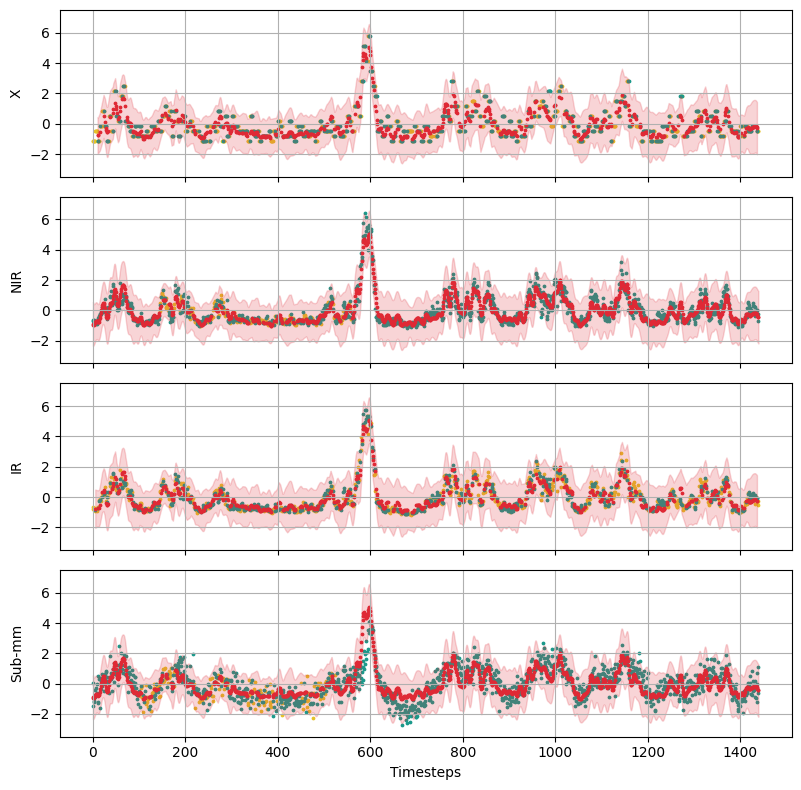

In [6]:
import torch
import matplotlib.pyplot as plt
from evaluator import Evaluator
from trainer import Trainer
from utils import *

data = get_dataset('sgra')
keys = ["X", 'NIR', "IR", "Sub-mm"]
num_keys = len(keys)
iterations = 1000
max_early_stop = 30

# Select a specific sample index
sample_idx = 150
sample = data[sample_idx]

# Process the data
train_x, train_idx, train_y, test_x, test_y, test_idx = process_data(sample, keys)

# Train the model
full_train_x = torch.cat(train_x)
full_train_idx = torch.cat(train_idx)
full_train_y = torch.cat(train_y)

trainer = Trainer(full_train_x, full_train_idx, full_train_y, 'gaussian', iterations=iterations, max_early_stop=max_early_stop)
model, likelihood = trainer.train_model()

evaluator = Evaluator(model, likelihood, test_x, test_idx, len(keys))
observed_preds = evaluator.evaluate()

# Create a plot for each key (wavelength)
fig, axes = plt.subplots(len(keys), 1, figsize=(8, 2 * len(keys)), sharex=True)

if len(keys) == 1:
    axes = [axes]  # Ensure axes is iterable for a single subplot

for i, key in enumerate(keys):
    train_xi = train_x[i].detach().numpy()
    train_yi = train_y[i].detach().numpy()
    test_xi = test_x[i].detach().numpy()
    test_yi = test_y[i].detach().numpy()

    means = observed_preds[i].mean.cpu().detach().numpy()
    lower, upper = observed_preds[i].confidence_region()
    lower, upper = lower.cpu().detach().numpy(), upper.cpu().detach().numpy()

    # Use ax_plot function to visualize the sample
    ax_plot(axes[i], train_yi, train_xi, test_yi, test_xi, means, lower, upper, label=key)

axes[-1].set_xlabel("Timesteps")
plt.tight_layout()
plt.show()


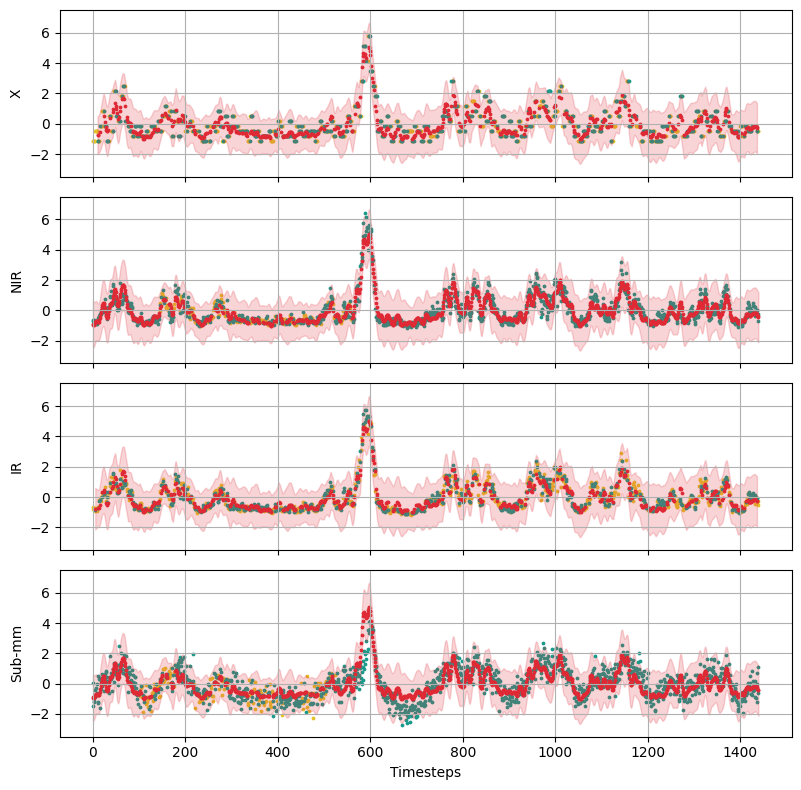

Results saved to model_results.npz


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from evaluator import Evaluator
from trainer import Trainer
from utils import *

data = get_dataset('sgra')
keys = ["X", 'NIR', "IR", "Sub-mm"]
num_keys = len(keys)
iterations = 1000
max_early_stop = 30

# Select a specific sample index
sample_idx = 150
sample = data[sample_idx]

# Process the data
train_x, train_idx, train_y, test_x, test_y, test_idx = process_data(sample, keys)

# Train the model
full_train_x = torch.cat(train_x)
full_train_idx = torch.cat(train_idx)
full_train_y = torch.cat(train_y)

trainer = Trainer(full_train_x, full_train_idx, full_train_y, 'gaussian', iterations=iterations, max_early_stop=max_early_stop)
model, likelihood = trainer.train_model()

evaluator = Evaluator(model, likelihood, test_x, test_idx, len(keys))
observed_preds = evaluator.evaluate()

# Prepare data for saving
saved_data = {}

# Create a plot for each key (wavelength)
fig, axes = plt.subplots(len(keys), 1, figsize=(8, 2 * len(keys)), sharex=True)

if len(keys) == 1:
    axes = [axes]  # Ensure axes is iterable for a single subplot

for i, key in enumerate(keys):
    train_xi = train_x[i].detach().numpy()
    train_yi = train_y[i].detach().numpy()
    test_xi = test_x[i].detach().numpy()
    test_yi = test_y[i].detach().numpy()

    means = observed_preds[i].mean.cpu().detach().numpy()
    lower, upper = observed_preds[i].confidence_region()
    lower, upper = lower.cpu().detach().numpy(), upper.cpu().detach().numpy()

    # Save results for this wavelength
    saved_data[f"{key}_train_x"] = train_xi
    saved_data[f"{key}_train_y"] = train_yi
    saved_data[f"{key}_test_x"] = test_xi
    saved_data[f"{key}_test_y"] = test_yi
    saved_data[f"{key}_predicted_means"] = means
    saved_data[f"{key}_lower_bound"] = lower
    saved_data[f"{key}_upper_bound"] = upper

    # Use ax_plot function to visualize the sample
    ax_plot(axes[i], train_yi, train_xi, test_yi, test_xi, means, lower, upper, label=key)

axes[-1].set_xlabel("Timesteps")
plt.tight_layout()
plt.show()

# Save data to a file
output_file = "model_results.npz"
np.savez(output_file, **saved_data)

print(f"Results saved to {output_file}")


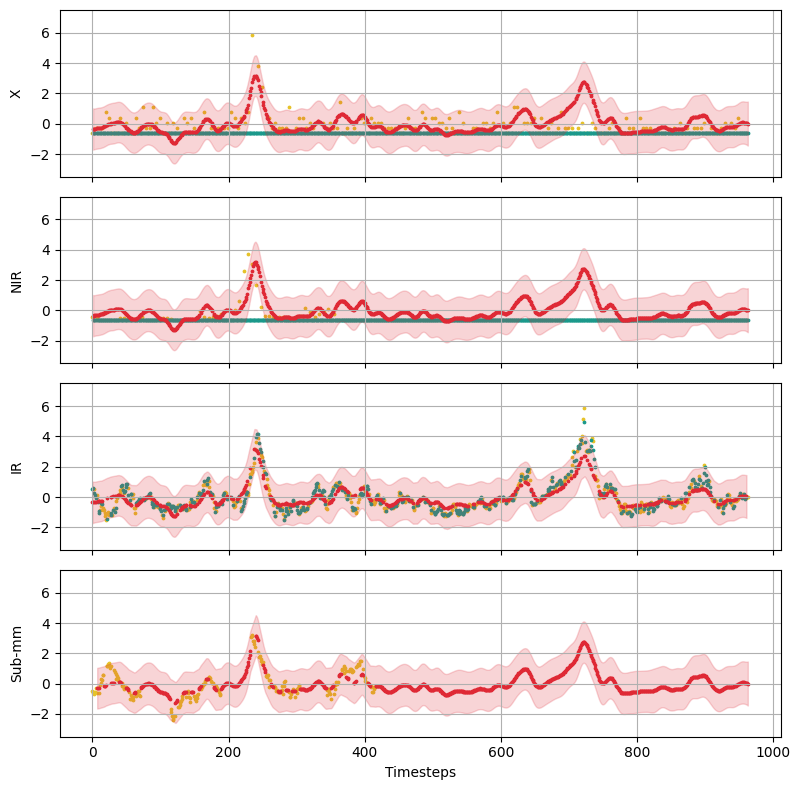

Results saved to real_results.npz


In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from evaluator import Evaluator
from trainer import Trainer
from utils import ax_plot

def process_real_data_for_mogp(real_data, keys):
    """
    Processes real data for MOGP model input.
    """
    dim = len(keys)
    sample = torch.tensor(real_data[0], dtype=torch.float32)

    train_x = []
    train_y = []
    train_idx = []
    test_x = []
    test_y = []
    test_idx = []

    for i in range(dim):
        train_xi = torch.where((sample[:, dim + i].int() == 1))[0].long()
        train_yi = sample[:, i][train_xi].float()
        train_idx_i = torch.zeros_like(train_xi, dtype=torch.long)

        test_xi = torch.where((sample[:, dim + i].int() == 0))[0].long()
        test_yi = sample[:, i][test_xi].float()
        test_idx_i = torch.zeros_like(test_xi, dtype=torch.long)

        train_x.append(train_xi.float())
        train_y.append(train_yi)
        train_idx.append(train_idx_i)

        test_x.append(test_xi.float())
        test_y.append(test_yi)
        test_idx.append(test_idx_i)

    return train_x, train_idx, train_y, test_x, test_y, test_idx

def run_mogp_on_real_data(real_data, keys, output_file="real_results.npz"):
    """
    Runs MOGP on the real data, plots the results, and saves them to a file.
    """
    train_x, train_idx, train_y, test_x, test_y, test_idx = process_real_data_for_mogp(real_data, keys)

    # Train the model
    full_train_x = torch.cat(train_x)
    full_train_idx = torch.cat(train_idx)
    full_train_y = torch.cat(train_y)

    trainer = Trainer(full_train_x, full_train_idx, full_train_y, 'gaussian', iterations=1000, max_early_stop=30)
    model, likelihood = trainer.train_model()

    evaluator = Evaluator(model, likelihood, test_x, test_idx, len(keys))
    observed_preds = evaluator.evaluate()

    # Create a plot for each key (wavelength)
    fig, axes = plt.subplots(len(keys), 1, figsize=(8, 2 * len(keys)), sharex=True)

    if len(keys) == 1:
        axes = [axes]

    saved_data = {}  # Dictionary to store results

    for i, key in enumerate(keys):
        train_xi = train_x[i].detach().numpy()
        train_yi = train_y[i].detach().numpy()
        test_xi = test_x[i].detach().numpy()
        test_yi = test_y[i].detach().numpy()

        means = observed_preds[i].mean.cpu().detach().numpy()
        lower, upper = observed_preds[i].confidence_region()
        lower, upper = lower.cpu().detach().numpy(), upper.cpu().detach().numpy()

        # Save results for this wavelength
        saved_data[f"{key}_train_x"] = train_xi
        saved_data[f"{key}_train_y"] = train_yi
        saved_data[f"{key}_test_x"] = test_xi
        saved_data[f"{key}_test_y"] = test_yi
        saved_data[f"{key}_predicted_means"] = means
        saved_data[f"{key}_lower_bound"] = lower
        saved_data[f"{key}_upper_bound"] = upper

        # Use ax_plot function to visualize the sample
        ax_plot(axes[i], train_yi, train_xi, test_yi, test_xi, means, lower, upper, label=key)

    axes[-1].set_xlabel("Timesteps")
    plt.tight_layout()
    plt.show()

    # Save data to a file
    np.savez(output_file, **saved_data)

    print(f"Results saved to {output_file}")

# Example Usage (assuming 'real_data' is your real data array):
real_data = np.load('../Analysis/real_data_mogp.npz')['real_data']
run_mogp_on_real_data(real_data, ["X", 'NIR', "IR", "Sub-mm"])

# Noise Analysis

## 10% Noise

In [1]:
import torch
from matplotlib import pyplot as plt
from utils import *
from trainer import Trainer
from evaluator import Evaluator
from tqdm import tqdm
import pandas as pd
import psutil
import os
import gc

def print_gpu_memory_usage(device=None):
    if device is None:
        device = torch.cuda.current_device()  # Get the current CUDA device
    allocated_memory = torch.cuda.memory_allocated(device) / 1024 / 1024  # Convert to MB
    cached_memory = torch.cuda.memory_reserved(device) / 1024 / 1024  # Convert to MB
    print(f"GPU Memory Usage (Allocated): {allocated_memory:.2f} MB")
    print(f"GPU Memory Usage (Cached): {cached_memory:.2f} MB")


%matplotlib inline
%load_ext autoreload
%autoreload 2

# Set up keys and other parameters
data = get_dataset('10_noise')
keys = ["X", 'NIR', "IR", "submm"]
iterations = 1000
max_early_stop = 30

# Initialize variables to accumulate total MSE and CRPS across all samples and wavelengths
total_mse_per_wavelength = {key: 0 for key in keys}
total_crps_per_wavelength = {key: 0 for key in keys}
total_mse_all = 0
total_crps_all = 0
num_samples = len(data)
num_keys = len(keys)

print(f'Dataset has {len(data)} samples')

# Iterate over the dataset
for idx, sample in enumerate(tqdm(data)):
    # Process the data
    train_x, train_idx, train_y, test_x, test_y, test_idx = process_data(sample, keys)
    full_train_x = torch.cat(train_x)
    full_train_idx = torch.cat(train_idx)
    full_train_y = torch.cat(train_y)

    # Train the model
    trainer = Trainer(full_train_x, full_train_idx, full_train_y, 'gaussian', iterations=iterations, max_early_stop=max_early_stop)
    model, likelihood = trainer.train_model()

    evaluator = Evaluator(model, likelihood, test_x, test_idx, num_keys)
    observed_preds = evaluator.evaluate()

    # Process the results for each key
    for i in range(num_keys):
        # Convert to numpy
        train_xi = train_x[i].detach().numpy()
        train_yi = train_y[i].detach().numpy()
        test_xi = test_x[i].detach().numpy()
        test_yi = test_y[i].detach().numpy()

        means = observed_preds[i].mean.cpu().detach().numpy()
        lower, upper = observed_preds[i].confidence_region()
        lower, upper = lower.detach().cpu().numpy(), upper.cpu().detach().numpy()
        standard_deviations = (upper - means) / 2.0

        # Calculate metrics
        crps = crps_norm(test_yi, means, standard_deviations)
        mse = mean_squared_error(test_yi, means)

        # Accumulate total metrics for each wavelength
        total_mse_per_wavelength[keys[i]] += mse
        total_crps_per_wavelength[keys[i]] += crps

        # Accumulate total metrics for the entire dataset
        total_mse_all += mse
        total_crps_all += crps
    
    del train_x, train_y, train_idx, test_x, test_y, test_idx, trainer, evaluator, model, likelihood, observed_preds, lower, upper, standard_deviations, means, full_train_x, full_train_y, full_train_idx, train_xi, train_yi, test_xi, test_yi
    torch.cuda.empty_cache()  # If using GPU
    gc.collect()
    
    # print_gpu_memory_usage()

# Calculate averages for each wavelength
average_mse_per_wavelength = {key: total_mse_per_wavelength[key] / num_samples for key in keys}
average_crps_per_wavelength = {key: total_crps_per_wavelength[key] / num_samples for key in keys}

# Calculate total averages for the entire dataset
average_mse_all = total_mse_all / (num_samples * num_keys)
average_crps_all = total_crps_all / (num_samples * num_keys)

# Prepare the results in a dictionary format
final_results = {
    "wavelength": keys,
    "average_mse": [average_mse_per_wavelength[key] for key in keys],
    "average_crps": [average_crps_per_wavelength[key] for key in keys],
    "total_average_mse": [average_mse_all] * len(keys),
    "total_average_crps": [average_crps_all] * len(keys),
}

# Create a DataFrame from the results
results_df = pd.DataFrame(final_results)

# Save the results to a CSV file
results_df.to_csv("10_noise.csv", index=False)

print("Processing complete. Results saved to '10_noise.csv'.")
print('Total MSE: ', [average_mse_all] * len(keys))

Dataset has 1635 samples


100%|██████████| 1635/1635 [1:33:09<00:00,  3.42s/it]

Processing complete. Results saved to '10_noise.csv'.
Total MSE:  [0.26443527353378066, 0.26443527353378066, 0.26443527353378066, 0.26443527353378066]


In [2]:
print(np.mean([0.26443527353378066, 0.26443527353378066, 0.26443527353378066, 0.26443527353378066]))

0.26443527353378066


## 30% Noise

In [ ]:
import torch
from matplotlib import pyplot as plt
from utils import *
from trainer import Trainer
from evaluator import Evaluator
from tqdm import tqdm
import pandas as pd
import psutil
import os
import gc

def print_gpu_memory_usage(device=None):
    if device is None:
        device = torch.cuda.current_device()  # Get the current CUDA device
    allocated_memory = torch.cuda.memory_allocated(device) / 1024 / 1024  # Convert to MB
    cached_memory = torch.cuda.memory_reserved(device) / 1024 / 1024  # Convert to MB
    print(f"GPU Memory Usage (Allocated): {allocated_memory:.2f} MB")
    print(f"GPU Memory Usage (Cached): {cached_memory:.2f} MB")


%matplotlib inline
%load_ext autoreload
%autoreload 2

# Set up keys and other parameters
data = get_dataset('30_noise')
keys = ["X", 'NIR', "IR", "submm"]
iterations = 1000
max_early_stop = 30

# Initialize variables to accumulate total MSE and CRPS across all samples and wavelengths
total_mse_per_wavelength = {key: 0 for key in keys}
total_crps_per_wavelength = {key: 0 for key in keys}
total_mse_all = 0
total_crps_all = 0
num_samples = len(data)
num_keys = len(keys)

print(f'Dataset has {len(data)} samples')

# Iterate over the dataset
for idx, sample in enumerate(tqdm(data)):
    # Process the data
    train_x, train_idx, train_y, test_x, test_y, test_idx = process_data(sample, keys)
    full_train_x = torch.cat(train_x)
    full_train_idx = torch.cat(train_idx)
    full_train_y = torch.cat(train_y)

    # Train the model
    trainer = Trainer(full_train_x, full_train_idx, full_train_y, 'gaussian', iterations=iterations, max_early_stop=max_early_stop)
    model, likelihood = trainer.train_model()

    evaluator = Evaluator(model, likelihood, test_x, test_idx, num_keys)
    observed_preds = evaluator.evaluate()

    # Process the results for each key
    for i in range(num_keys):
        # Convert to numpy
        train_xi = train_x[i].detach().numpy()
        train_yi = train_y[i].detach().numpy()
        test_xi = test_x[i].detach().numpy()
        test_yi = test_y[i].detach().numpy()

        means = observed_preds[i].mean.cpu().detach().numpy()
        lower, upper = observed_preds[i].confidence_region()
        lower, upper = lower.detach().cpu().numpy(), upper.cpu().detach().numpy()
        standard_deviations = (upper - means) / 2.0

        # Calculate metrics
        crps = crps_norm(test_yi, means, standard_deviations)
        mse = mean_squared_error(test_yi, means)

        # Accumulate total metrics for each wavelength
        total_mse_per_wavelength[keys[i]] += mse
        total_crps_per_wavelength[keys[i]] += crps

        # Accumulate total metrics for the entire dataset
        total_mse_all += mse
        total_crps_all += crps
    
    del train_x, train_y, train_idx, test_x, test_y, test_idx, trainer, evaluator, model, likelihood, observed_preds, lower, upper, standard_deviations, means, full_train_x, full_train_y, full_train_idx, train_xi, train_yi, test_xi, test_yi
    torch.cuda.empty_cache()  # If using GPU
    gc.collect()
    
    # print_gpu_memory_usage()

# Calculate averages for each wavelength
average_mse_per_wavelength = {key: total_mse_per_wavelength[key] / num_samples for key in keys}
average_crps_per_wavelength = {key: total_crps_per_wavelength[key] / num_samples for key in keys}

# Calculate total averages for the entire dataset
average_mse_all = total_mse_all / (num_samples * num_keys)
average_crps_all = total_crps_all / (num_samples * num_keys)

# Prepare the results in a dictionary format
final_results = {
    "wavelength": keys,
    "average_mse": [average_mse_per_wavelength[key] for key in keys],
    "average_crps": [average_crps_per_wavelength[key] for key in keys],
    "total_average_mse": [average_mse_all] * len(keys),
    "total_average_crps": [average_crps_all] * len(keys),
}

# Create a DataFrame from the results
results_df = pd.DataFrame(final_results)

# Save the results to a CSV file
results_df.to_csv("30_noise.csv", index=False)

print("Processing complete. Results saved to '30_noise.csv'.")
print('Total MSE: ', [average_mse_all] * len(keys))

## 50% Noise

In [ ]:
import torch
from matplotlib import pyplot as plt
from utils import *
from trainer import Trainer
from evaluator import Evaluator
from tqdm import tqdm
import pandas as pd
import psutil
import os
import gc

def print_gpu_memory_usage(device=None):
    if device is None:
        device = torch.cuda.current_device()  # Get the current CUDA device
    allocated_memory = torch.cuda.memory_allocated(device) / 1024 / 1024  # Convert to MB
    cached_memory = torch.cuda.memory_reserved(device) / 1024 / 1024  # Convert to MB
    print(f"GPU Memory Usage (Allocated): {allocated_memory:.2f} MB")
    print(f"GPU Memory Usage (Cached): {cached_memory:.2f} MB")


%matplotlib inline
%load_ext autoreload
%autoreload 2

# Set up keys and other parameters
data = get_dataset('50_noise')
keys = ["X", 'NIR', "IR", "submm"]
iterations = 1000
max_early_stop = 30

# Initialize variables to accumulate total MSE and CRPS across all samples and wavelengths
total_mse_per_wavelength = {key: 0 for key in keys}
total_crps_per_wavelength = {key: 0 for key in keys}
total_mse_all = 0
total_crps_all = 0
num_samples = len(data)
num_keys = len(keys)

print(f'Dataset has {len(data)} samples')

# Iterate over the dataset
for idx, sample in enumerate(tqdm(data)):
    # Process the data
    train_x, train_idx, train_y, test_x, test_y, test_idx = process_data(sample, keys)
    full_train_x = torch.cat(train_x)
    full_train_idx = torch.cat(train_idx)
    full_train_y = torch.cat(train_y)

    # Train the model
    trainer = Trainer(full_train_x, full_train_idx, full_train_y, 'gaussian', iterations=iterations, max_early_stop=max_early_stop)
    model, likelihood = trainer.train_model()

    evaluator = Evaluator(model, likelihood, test_x, test_idx, num_keys)
    observed_preds = evaluator.evaluate()

    # Process the results for each key
    for i in range(num_keys):
        # Convert to numpy
        train_xi = train_x[i].detach().numpy()
        train_yi = train_y[i].detach().numpy()
        test_xi = test_x[i].detach().numpy()
        test_yi = test_y[i].detach().numpy()

        means = observed_preds[i].mean.cpu().detach().numpy()
        lower, upper = observed_preds[i].confidence_region()
        lower, upper = lower.detach().cpu().numpy(), upper.cpu().detach().numpy()
        standard_deviations = (upper - means) / 2.0

        # Calculate metrics
        crps = crps_norm(test_yi, means, standard_deviations)
        mse = mean_squared_error(test_yi, means)

        # Accumulate total metrics for each wavelength
        total_mse_per_wavelength[keys[i]] += mse
        total_crps_per_wavelength[keys[i]] += crps

        # Accumulate total metrics for the entire dataset
        total_mse_all += mse
        total_crps_all += crps
    
    del train_x, train_y, train_idx, test_x, test_y, test_idx, trainer, evaluator, model, likelihood, observed_preds, lower, upper, standard_deviations, means, full_train_x, full_train_y, full_train_idx, train_xi, train_yi, test_xi, test_yi
    torch.cuda.empty_cache()  # If using GPU
    gc.collect()
    
    # print_gpu_memory_usage()

# Calculate averages for each wavelength
average_mse_per_wavelength = {key: total_mse_per_wavelength[key] / num_samples for key in keys}
average_crps_per_wavelength = {key: total_crps_per_wavelength[key] / num_samples for key in keys}

# Calculate total averages for the entire dataset
average_mse_all = total_mse_all / (num_samples * num_keys)
average_crps_all = total_crps_all / (num_samples * num_keys)

# Prepare the results in a dictionary format
final_results = {
    "wavelength": keys,
    "average_mse": [average_mse_per_wavelength[key] for key in keys],
    "average_crps": [average_crps_per_wavelength[key] for key in keys],
    "total_average_mse": [average_mse_all] * len(keys),
    "total_average_crps": [average_crps_all] * len(keys),
}

# Create a DataFrame from the results
results_df = pd.DataFrame(final_results)

# Save the results to a CSV file
results_df.to_csv("50_noise.csv", index=False)

print("Processing complete. Results saved to '50_noise.csv'.")
print('Total MSE: ', [average_mse_all] * len(keys))

## 70% Noise

In [ ]:
import torch
from matplotlib import pyplot as plt
from utils import *
from trainer import Trainer
from evaluator import Evaluator
from tqdm import tqdm
import pandas as pd
import psutil
import os
import gc

def print_gpu_memory_usage(device=None):
    if device is None:
        device = torch.cuda.current_device()  # Get the current CUDA device
    allocated_memory = torch.cuda.memory_allocated(device) / 1024 / 1024  # Convert to MB
    cached_memory = torch.cuda.memory_reserved(device) / 1024 / 1024  # Convert to MB
    print(f"GPU Memory Usage (Allocated): {allocated_memory:.2f} MB")
    print(f"GPU Memory Usage (Cached): {cached_memory:.2f} MB")


%matplotlib inline
%load_ext autoreload
%autoreload 2

# Set up keys and other parameters
data = get_dataset('70_noise')
keys = ["X", 'NIR', "IR", "submm"]
iterations = 1000
max_early_stop = 30

# Initialize variables to accumulate total MSE and CRPS across all samples and wavelengths
total_mse_per_wavelength = {key: 0 for key in keys}
total_crps_per_wavelength = {key: 0 for key in keys}
total_mse_all = 0
total_crps_all = 0
num_samples = len(data)
num_keys = len(keys)

print(f'Dataset has {len(data)} samples')

# Iterate over the dataset
for idx, sample in enumerate(tqdm(data)):
    # Process the data
    train_x, train_idx, train_y, test_x, test_y, test_idx = process_data(sample, keys)
    full_train_x = torch.cat(train_x)
    full_train_idx = torch.cat(train_idx)
    full_train_y = torch.cat(train_y)

    # Train the model
    trainer = Trainer(full_train_x, full_train_idx, full_train_y, 'gaussian', iterations=iterations, max_early_stop=max_early_stop)
    model, likelihood = trainer.train_model()

    evaluator = Evaluator(model, likelihood, test_x, test_idx, num_keys)
    observed_preds = evaluator.evaluate()

    # Process the results for each key
    for i in range(num_keys):
        # Convert to numpy
        train_xi = train_x[i].detach().numpy()
        train_yi = train_y[i].detach().numpy()
        test_xi = test_x[i].detach().numpy()
        test_yi = test_y[i].detach().numpy()

        means = observed_preds[i].mean.cpu().detach().numpy()
        lower, upper = observed_preds[i].confidence_region()
        lower, upper = lower.detach().cpu().numpy(), upper.cpu().detach().numpy()
        standard_deviations = (upper - means) / 2.0

        # Calculate metrics
        crps = crps_norm(test_yi, means, standard_deviations)
        mse = mean_squared_error(test_yi, means)

        # Accumulate total metrics for each wavelength
        total_mse_per_wavelength[keys[i]] += mse
        total_crps_per_wavelength[keys[i]] += crps

        # Accumulate total metrics for the entire dataset
        total_mse_all += mse
        total_crps_all += crps
    
    del train_x, train_y, train_idx, test_x, test_y, test_idx, trainer, evaluator, model, likelihood, observed_preds, lower, upper, standard_deviations, means, full_train_x, full_train_y, full_train_idx, train_xi, train_yi, test_xi, test_yi
    torch.cuda.empty_cache()  # If using GPU
    gc.collect()
    
    # print_gpu_memory_usage()

# Calculate averages for each wavelength
average_mse_per_wavelength = {key: total_mse_per_wavelength[key] / num_samples for key in keys}
average_crps_per_wavelength = {key: total_crps_per_wavelength[key] / num_samples for key in keys}

# Calculate total averages for the entire dataset
average_mse_all = total_mse_all / (num_samples * num_keys)
average_crps_all = total_crps_all / (num_samples * num_keys)

# Prepare the results in a dictionary format
final_results = {
    "wavelength": keys,
    "average_mse": [average_mse_per_wavelength[key] for key in keys],
    "average_crps": [average_crps_per_wavelength[key] for key in keys],
    "total_average_mse": [average_mse_all] * len(keys),
    "total_average_crps": [average_crps_all] * len(keys),
}

# Create a DataFrame from the results
results_df = pd.DataFrame(final_results)

# Save the results to a CSV file
results_df.to_csv("70_noise.csv", index=False)

print("Processing complete. Results saved to '70_noise.csv'.")
print('Total MSE: ', [average_mse_all] * len(keys))

## 90% Noise

In [ ]:
import torch
from matplotlib import pyplot as plt
from utils import *
from trainer import Trainer
from evaluator import Evaluator
from tqdm import tqdm
import pandas as pd
import psutil
import os
import gc

def print_gpu_memory_usage(device=None):
    if device is None:
        device = torch.cuda.current_device()  # Get the current CUDA device
    allocated_memory = torch.cuda.memory_allocated(device) / 1024 / 1024  # Convert to MB
    cached_memory = torch.cuda.memory_reserved(device) / 1024 / 1024  # Convert to MB
    print(f"GPU Memory Usage (Allocated): {allocated_memory:.2f} MB")
    print(f"GPU Memory Usage (Cached): {cached_memory:.2f} MB")


%matplotlib inline
%load_ext autoreload
%autoreload 2

# Set up keys and other parameters
data = get_dataset('90_noise')
keys = ["X", 'NIR', "IR", "submm"]
iterations = 1000
max_early_stop = 30

# Initialize variables to accumulate total MSE and CRPS across all samples and wavelengths
total_mse_per_wavelength = {key: 0 for key in keys}
total_crps_per_wavelength = {key: 0 for key in keys}
total_mse_all = 0
total_crps_all = 0
num_samples = len(data)
num_keys = len(keys)

print(f'Dataset has {len(data)} samples')

# Iterate over the dataset
for idx, sample in enumerate(tqdm(data)):
    # Process the data
    train_x, train_idx, train_y, test_x, test_y, test_idx = process_data(sample, keys)
    full_train_x = torch.cat(train_x)
    full_train_idx = torch.cat(train_idx)
    full_train_y = torch.cat(train_y)

    # Train the model
    trainer = Trainer(full_train_x, full_train_idx, full_train_y, 'gaussian', iterations=iterations, max_early_stop=max_early_stop)
    model, likelihood = trainer.train_model()

    evaluator = Evaluator(model, likelihood, test_x, test_idx, num_keys)
    observed_preds = evaluator.evaluate()

    # Process the results for each key
    for i in range(num_keys):
        # Convert to numpy
        train_xi = train_x[i].detach().numpy()
        train_yi = train_y[i].detach().numpy()
        test_xi = test_x[i].detach().numpy()
        test_yi = test_y[i].detach().numpy()

        means = observed_preds[i].mean.cpu().detach().numpy()
        lower, upper = observed_preds[i].confidence_region()
        lower, upper = lower.detach().cpu().numpy(), upper.cpu().detach().numpy()
        standard_deviations = (upper - means) / 2.0

        # Calculate metrics
        crps = crps_norm(test_yi, means, standard_deviations)
        mse = mean_squared_error(test_yi, means)

        # Accumulate total metrics for each wavelength
        total_mse_per_wavelength[keys[i]] += mse
        total_crps_per_wavelength[keys[i]] += crps

        # Accumulate total metrics for the entire dataset
        total_mse_all += mse
        total_crps_all += crps
    
    del train_x, train_y, train_idx, test_x, test_y, test_idx, trainer, evaluator, model, likelihood, observed_preds, lower, upper, standard_deviations, means, full_train_x, full_train_y, full_train_idx, train_xi, train_yi, test_xi, test_yi
    torch.cuda.empty_cache()  # If using GPU
    gc.collect()
    
    # print_gpu_memory_usage()

# Calculate averages for each wavelength
average_mse_per_wavelength = {key: total_mse_per_wavelength[key] / num_samples for key in keys}
average_crps_per_wavelength = {key: total_crps_per_wavelength[key] / num_samples for key in keys}

# Calculate total averages for the entire dataset
average_mse_all = total_mse_all / (num_samples * num_keys)
average_crps_all = total_crps_all / (num_samples * num_keys)

# Prepare the results in a dictionary format
final_results = {
    "wavelength": keys,
    "average_mse": [average_mse_per_wavelength[key] for key in keys],
    "average_crps": [average_crps_per_wavelength[key] for key in keys],
    "total_average_mse": [average_mse_all] * len(keys),
    "total_average_crps": [average_crps_all] * len(keys),
}

# Create a DataFrame from the results
results_df = pd.DataFrame(final_results)

# Save the results to a CSV file
results_df.to_csv("90_noise.csv", index=False)

print("Processing complete. Results saved to '90_noise.csv'.")
print('Total MSE: ', [average_mse_all] * len(keys))

## 95% Noise

In [ ]:
import torch
from matplotlib import pyplot as plt
from utils import *
from trainer import Trainer
from evaluator import Evaluator
from tqdm import tqdm
import pandas as pd
import psutil
import os
import gc

def print_gpu_memory_usage(device=None):
    if device is None:
        device = torch.cuda.current_device()  # Get the current CUDA device
    allocated_memory = torch.cuda.memory_allocated(device) / 1024 / 1024  # Convert to MB
    cached_memory = torch.cuda.memory_reserved(device) / 1024 / 1024  # Convert to MB
    print(f"GPU Memory Usage (Allocated): {allocated_memory:.2f} MB")
    print(f"GPU Memory Usage (Cached): {cached_memory:.2f} MB")


%matplotlib inline
%load_ext autoreload
%autoreload 2

# Set up keys and other parameters
data = get_dataset('95_noise')
keys = ["X", 'NIR', "IR", "submm"]
iterations = 1000
max_early_stop = 30

# Initialize variables to accumulate total MSE and CRPS across all samples and wavelengths
total_mse_per_wavelength = {key: 0 for key in keys}
total_crps_per_wavelength = {key: 0 for key in keys}
total_mse_all = 0
total_crps_all = 0
num_samples = len(data)
num_keys = len(keys)

print(f'Dataset has {len(data)} samples')

# Iterate over the dataset
for idx, sample in enumerate(tqdm(data)):
    # Process the data
    train_x, train_idx, train_y, test_x, test_y, test_idx = process_data(sample, keys)
    full_train_x = torch.cat(train_x)
    full_train_idx = torch.cat(train_idx)
    full_train_y = torch.cat(train_y)

    # Train the model
    trainer = Trainer(full_train_x, full_train_idx, full_train_y, 'gaussian', iterations=iterations, max_early_stop=max_early_stop)
    model, likelihood = trainer.train_model()

    evaluator = Evaluator(model, likelihood, test_x, test_idx, num_keys)
    observed_preds = evaluator.evaluate()

    # Process the results for each key
    for i in range(num_keys):
        # Convert to numpy
        train_xi = train_x[i].detach().numpy()
        train_yi = train_y[i].detach().numpy()
        test_xi = test_x[i].detach().numpy()
        test_yi = test_y[i].detach().numpy()

        means = observed_preds[i].mean.cpu().detach().numpy()
        lower, upper = observed_preds[i].confidence_region()
        lower, upper = lower.detach().cpu().numpy(), upper.cpu().detach().numpy()
        standard_deviations = (upper - means) / 2.0

        # Calculate metrics
        crps = crps_norm(test_yi, means, standard_deviations)
        mse = mean_squared_error(test_yi, means)

        # Accumulate total metrics for each wavelength
        total_mse_per_wavelength[keys[i]] += mse
        total_crps_per_wavelength[keys[i]] += crps

        # Accumulate total metrics for the entire dataset
        total_mse_all += mse
        total_crps_all += crps
    
    del train_x, train_y, train_idx, test_x, test_y, test_idx, trainer, evaluator, model, likelihood, observed_preds, lower, upper, standard_deviations, means, full_train_x, full_train_y, full_train_idx, train_xi, train_yi, test_xi, test_yi
    torch.cuda.empty_cache()  # If using GPU
    gc.collect()
    
    # print_gpu_memory_usage()

# Calculate averages for each wavelength
average_mse_per_wavelength = {key: total_mse_per_wavelength[key] / num_samples for key in keys}
average_crps_per_wavelength = {key: total_crps_per_wavelength[key] / num_samples for key in keys}

# Calculate total averages for the entire dataset
average_mse_all = total_mse_all / (num_samples * num_keys)
average_crps_all = total_crps_all / (num_samples * num_keys)

# Prepare the results in a dictionary format
final_results = {
    "wavelength": keys,
    "average_mse": [average_mse_per_wavelength[key] for key in keys],
    "average_crps": [average_crps_per_wavelength[key] for key in keys],
    "total_average_mse": [average_mse_all] * len(keys),
    "total_average_crps": [average_crps_all] * len(keys),
}

# Create a DataFrame from the results
results_df = pd.DataFrame(final_results)

# Save the results to a CSV file
results_df.to_csv("95_noise.csv", index=False)

print("Processing complete. Results saved to '95_noise.csv'.")
print('Total MSE: ', [average_mse_all] * len(keys))